In [1]:
import pandas as pd
from glob import glob
import numpy as np
from tools.procOps import *
from tools.fileOps import *
from collections import *
import itertools
from scipy.special import *
from tools.bio import *

In [44]:
# load feature set
sun_df = pd.read_csv('hg38_features_ab_merge.txt', sep='\t')
sun_df = sun_df[(sun_df.AB == 4) | (sun_df.AB == 0)]

In [45]:
sun_df.columns = ['loc', 'NAB', 'NC', 'ND', 'NN']
sun_df['NAB'] = [1 if x > 0 else 0 for x in sun_df['NAB']]
sun_df['NC'] = [1 if x > 0 else 0 for x in sun_df['NC']]
sun_df['ND'] = [1 if x > 0 else 0 for x in sun_df['ND']]
sun_df['NN'] = [1 if x > 0 else 0 for x in sun_df['NN']]

In [46]:
bad_positions = set([22019, 80389, 54799, 88082, 77847, 16413, 69153, 25125, 8113, 85546, 18988, 19503, 65587, 75829, 28726, 48696, 12277, 2621, 14398, 90549, 40517, 2129, 68695, 2136, 62558, 66149, 16993, 43621, 55398, 4202, 60434, 13422, 56509, 96371, 4212, 74357, 86646, 76407, 44664, 30843, 35946, 42113, 39042, 80009, 10892, 4710, 63128, 67739, 30876, 24733, 19474, 91643, 91296, 47265, 23202, 30887, 18088, 52907, 78512, 10417, 58035, 89780, 89782, 48823, 43197, 48928, 31939, 72392, 72394, 32973, 93902, 50389, 45282, 76923, 56558, 65776, 67831, 69880, 91899, 71941, 3337, 9996, 87682, 75535, 62738, 56195, 46356, 25881, 9519, 50461, 15134, 90912, 71472, 26402, 31012, 15656, 24876, 69934, 31023, 98096, 3378, 90420, 76603, 56636, 12260, 87605, 70465, 59716, 76101, 60230, 71782, 84299, 88175, 78162, 61267, 76116, 42837, 9700, 10586, 65373, 76126, 7010, 59236, 14182, 37735, 4978, 50040, 18340, 26497, 76163, 97668, 91969, 9099, 9614, 40341, 94191, 7584, 19952, 69539, 70052, 96173, 87197, 42929, 51637, 38838, 54200, 18363, 94140, 61885, 77758, 43455, 43459, 55749, 50119, 3239, 95223, 94161, 79198, 42454, 64985, 28123, 89052, 94174, 12256, 40865, 27643, 51684, 45542, 2641, 50152, 93162, 28839, 92141, 87549, 27632, 48808, 66546, 52152, 95221, 26102, 41463, 48632, 95225, 95227, 95229, 77823])

bad_sites = {3707,
 4318,
 4320,
 4993,
 5919,
 7067,
 7109,
 7127,
 7168,
 7946,
 9975,
 14533,
 14895,
 16399,
 16634,
 16636,
 18995,
 19073,
 19334,
 19519,
 19707,
 19799,
 20061,
 20633,
 21426,
 22136,
 25367,
 28794,
 29037,
 29419,
 31878,
 34102,
 35605,
 35736,
 36957,
 37712,
 37885,
 38249,
 38378,
 38911,
 38970,
 39531,
 40316,
 40893,
 40936,
 41334,
 43560,
 43866,
 44729,
 48317,
 48371,
 48459,
 48494,
 48667,
 48729,
 48850,
 50300,
 51115,
 51277,
 52027,
 52381,
 53881,
 54024,
 54155,
 56412,
 59276,
 60194,
 60211,
 60249,
 60332,
 60777,
 61054,
 61183,
 61269,
 61384,
 61412,
 61520,
 61712,
 61751,
 61871,
 61879,
 61935,
 62062,
 62183,
 62241,
 62255,
 62634,
 62663,
 62673,
 62727,
 62933,
 63065,
 63582,
 63597,
 63659,
 63839,
 64045,
 64202,
 65517,
 65790,
 66343,
 66364,
 66422,
 66563,
 67142,
 67708,
 67759,
 68504,
 68540,
 68618,
 68781,
 68829,
 69027,
 69555,
 70323,
 70991,
 71286,
 72523,
 73523,
 73872,
 74402,
 74453,
 74715,
 74988,
 75378,
 75685,
 76273,
 76318,
 77952,
 77974,
 77993,
 83971,
 84665,
 85952,
 86216,
 86295,
 86801,
 86915,
 87000,
 88135,
 89160,
 89444,
 89449,
 89849,
 89878,
 90003,
 90052,
 90150,
 90808,
 91023,
 91308,
 91748,
 91784,
 91799,
 92254,
 92594,
 92684,
 93655,
 94116,
 94612,
 94728,
 94754,
 94788,
 95231,
 95493,
 95678,
 96330,
 96369,
 97720,
 97972,
 97980}
sun_df = sun_df[~sun_df['loc'].isin(bad_positions | bad_sites)]

In [11]:
# now try this on real data

# load parsed pileups
files = glob('/hive/users/ifiddes/simons_normals/*.parsed_pileup.txt')
dfs = {}
for f in files:
    n = os.path.basename(f).split('.')[0]
    dfs[n] = pd.read_csv(f, sep='\t', index_col=0)
    
# load C/D copy number estimates

files = glob('/hive/users/ifiddes/simons_normals/*.filtered.txt')
def convert(x):
    x = x.split(':')
    n, v = x
    v = int(v)
    return n, v

copy_number = {}
for x in files:
    n = os.path.basename(x).split('.')[0]
    l = open(x).next().rstrip().split()
    c = []
    for x in l[2:4]:
        _, v = convert(x)
        c.append(v)
    copy_number[n] = c
    
    
# filter dataframes for C = 2 and D = 2
# also filter for informative positions
filtered_dfs = {}
for n, df in dfs.iteritems():
    c = copy_number[n]
    if sum(c) != 4:
        continue
    df_m = df.merge(sun_df, on='loc')
    df_m = df_m[df_m['loc'].isin(sun_df['loc'])]
    filtered_dfs[n] = df_m

In [47]:
# filter SUNs because there are 3 loci missing in the real data for some reason
filtered_sun_df = sun_df[sun_df['loc'].isin(df_m['loc'])]

In [50]:
# allow anywhere from 7 to 12 haplotypes
min_n = 7
max_n = 12

# range of possible genotypes
genotypes = range(0, 6)  # [0, 1, 2, 3, 4, 5]

# number of columns
num_paratypes = 4
r = []
for i in itertools.product(genotypes, repeat=num_paratypes):
    if min_n <= np.sum(i) <= max_n:
        r.append(i)

H = np.array(r).astype(float)
print 'first 10 proposed haplotypes:'
print H[:10]

first 10 proposed haplotypes:
[[ 0.  0.  2.  5.]
 [ 0.  0.  3.  4.]
 [ 0.  0.  3.  5.]
 [ 0.  0.  4.  3.]
 [ 0.  0.  4.  4.]
 [ 0.  0.  4.  5.]
 [ 0.  0.  5.  2.]
 [ 0.  0.  5.  3.]
 [ 0.  0.  5.  4.]
 [ 0.  0.  5.  5.]]


In [51]:
# load actual data from pileups into actual_alt, synthetic_alt, depth, s
actual_alt = []
synthetic_alt = []
depth = []
s_matrix = []  # genotype matrix


# filter using bias from previous iteration
f = filtered_sun_df[~filtered_sun_df['loc'].isin(bad_sites)]
f = f.set_index('loc').as_matrix()

# bad genomes
bad_genomes = ['LP6005677-DNA_A02', 'LP6005441-DNA_F01']

#seen_genomes = set()
for n, df_m in filtered_dfs.items():
    if n in bad_genomes:
        continue
    for _, s in df_m.iterrows():
        if s['loc'] not in set(filtered_sun_df['loc']) or s['loc'] in bad_sites:
            continue
        if s.coverage >= 10 and s.ratio >= 0.01:
            actual_alt.append(s.alt_count)
            depth.append(s.coverage)
        else:
            depth.append(0)
            actual_alt.append(0)
    # always 4-2-2-2
    s_matrix.append([4, 2, 2, 2])
    #seen_genomes.add(n)

In [52]:
# calculate total depth at each position
tot = []
for n, df_m in filtered_dfs.iteritems():
    df_m = df_m[(df_m['loc'].isin(filtered_sun_df['loc'])) & (~df_m['loc'].isin(bad_sites))]
    tot.append(df_m.coverage)
tot = np.array(tot)
tot = tot.sum(axis=0)

In [53]:
depth = np.array(depth).reshape(102, f.shape[0]).T
actual_alt = np.array(actual_alt).reshape(102, f.shape[0]).T
s = np.array(s_matrix).T

In [54]:
# calculate synthetic depth for all genomes
tsa = (np.multiply(depth, np.dot(f, s)) / 10).sum(axis=1)  # ploidy is always 10

In [55]:
taa = actual_alt.sum(axis=1)

In [56]:
depth_total = depth.sum(axis=1)

In [57]:
synthetic_alt = []
for h in H:
    synthetic_alt.append(np.multiply(depth_total, np.dot(f, h)) / sum(h))
synthetic_alt = np.array(synthetic_alt)

In [58]:
bias = 1.0 * taa / tsa

In [59]:
projected_alt = np.multiply(synthetic_alt, bias)

In [60]:
projected_ref = depth_total - projected_alt

In [61]:
u = projected_alt / (projected_alt + projected_ref)
a_matrix = u * (tot - 1)
b_matrix = (1 - u) * (tot  - 1)

In [62]:
# mix a and b slightly to give noise
delta = 0.001
aprime = (1 - delta) * a_matrix + delta * b_matrix
bprime = (1 - delta) * b_matrix + delta * a_matrix

In [63]:
# now lets try predicting copy number across the whole cohort

def r_fn(aprime, bprime, m, n):
    r_values = []
    for a, b in zip(aprime, bprime):
        r_values.append(np.sum(betaln(m + a, n + b) - betaln(a, b)))
    return r_values

In [64]:
# filter by bias
#bad_sites = set()
#for i, b in enumerate(bias):
#    if not (0.9 < b < 1.1):
#        bad_sites.add(filtered_sun_df.iloc[i]['loc'])

In [65]:
results = []
for g, df_m in dfs.iteritems():
    df_m = df_m[(df_m['loc'].isin(filtered_sun_df['loc'])) & (~df_m['loc'].isin(bad_sites))]
    m = df_m.alt_count
    n = df_m.ref_count
    r_values = r_fn(aprime, bprime, m, n)
    # figure out which one was the best scoring
    r_map = {i: x for i, x in enumerate(r_values)}
    best_index, score = sorted(r_map.iteritems(), key=lambda x: x[1])[-1]
    best_haps = H[best_index]
    results.append([g] + list(best_haps))

In [66]:
results = pd.DataFrame(results, columns=['genome', 'NAB', 'NC', 'ND', 'NN'])
results = results[~results.genome.isin(bad_genomes)]
results.head()

,genome,NAB,NC,ND,NN
0,SS6004480,5.0,2.0,1.0,3.0
1,LP6005441-DNA_D11,4.0,2.0,1.0,2.0
2,LP6005519-DNA_G02,4.0,2.0,1.0,2.0
3,LP6005519-DNA_G04,4.0,2.0,1.0,2.0
4,LP6005441-DNA_B03,5.0,2.0,1.0,3.0


In [67]:
Counter(results.NAB)

Counter({3.0: 1, 4.0: 219, 5.0: 44})

In [68]:
Counter(results.NC)

Counter({0.0: 1, 1.0: 17, 2.0: 244, 3.0: 2})

In [69]:
Counter(results.ND)

Counter({0.0: 36, 1.0: 107, 2.0: 120, 3.0: 1})

In [70]:
Counter(results.NN)

Counter({2.0: 209, 3.0: 51, 4.0: 4})

In [71]:
Counter(results.set_index('genome').sum(axis=1))

Counter({7.0: 2, 8.0: 12, 9.0: 85, 10.0: 143, 11.0: 22})

In [367]:
# figure out which one was the best scoring
m = df_m.alt_count
n = df_m.ref_count
r_values = r_fn(aprime, bprime, m, n)
# figure out which one was the best scoring
r_map = {i: x for i, x in enumerate(r_values)}
best_index, score = sorted(r_map.iteritems(), key=lambda x: x[1])[-1]
best_haps = H[best_index]
ordered = sorted(r_map.iteritems(), key=lambda x: x[1])[-10:][::-1]
print 'log odds: {}'.format(score)
print ''
print 'results: '
for x, y in zip(sun_df.columns[1:], best_haps):
    if y > 0:
        print '{}: {}'.format(x, y)

print ' '.join(sun_df.columns[1:])
print 'top 10 hits:'
for i, x in enumerate([[H[pos], pos, val] for pos, val in ordered], 1):
    print '{}: {}'.format(i, x)


log odds: -83474.0862732

results: 
NAB: 4.0
NC: 3.0
ND: 2.0
NN: 2.0
NAB NC ND NN
top 10 hits:
1: [array([ 4.,  3.,  2.,  2.]), 545, -83474.08627319903]
2: [array([ 5.,  3.,  2.,  2.]), 656, -83707.78800432892]
3: [array([ 4.,  4.,  2.,  2.]), 564, -83938.25200824531]
4: [array([ 3.,  3.,  2.,  2.]), 416, -83950.13466311186]
5: [array([ 4.,  2.,  2.,  2.]), 521, -84051.0668517208]
6: [array([ 4.,  3.,  3.,  2.]), 549, -84073.36539367499]
7: [array([ 3.,  2.,  1.,  2.]), 384, -84081.84400771832]
8: [array([ 3.,  2.,  2.,  1.]), 388, -84119.16395575868]
9: [array([ 4.,  3.,  2.,  3.]), 546, -84128.56204784538]
10: [array([ 3.,  3.,  1.,  2.]), 410, -84404.7162094571]


In [422]:
def calculate_deviance(s):
    if s.alt_count == 0 or s.coverage <= 20:
        return None
    deviance = (s.adjusted_alt - s.alt_count) / (np.sqrt(1.0 * s.coverage * s.ratio * (1 - s.ratio)))
    #deviance = (s.expected_alt - s.alt_count) / (np.sqrt(1.0 * s.coverage * s.ratio * (1 - s.ratio)))
    return deviance


def calculate_expected(s, tot):
    """Expected value"""
    expected_ratio = (1.0 * s.NAB + s.NC + s.ND + s.NN) / tot
    return expected_ratio * s.coverage


df = dfs['LP6005592-DNA_H03']
df_m = df.merge(sun_df, on='loc')
df_m = df_m[df_m['loc'].isin(filtered_sun_df['loc'])]
df_m = df_m[~df_m['loc'].isin(bad_sites)]
df_m['adjusted_alt'] = df_m['alt_count'] * bias
df_m['expected_alt'] = df_m.apply(calculate_expected, axis=1, tot=10)
df_m['deviance'] = df_m.apply(calculate_deviance, axis=1)

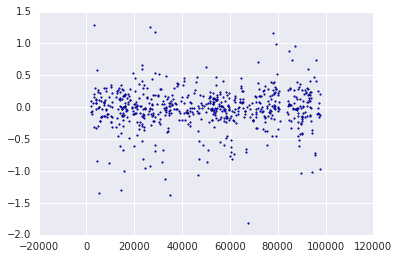

In [423]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(df_m['loc'], df_m['deviance'], s=3)

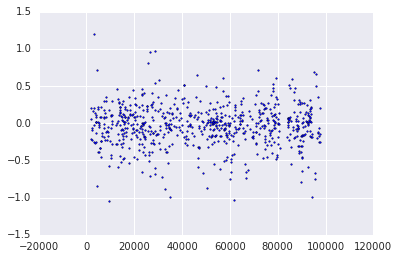

In [351]:
df_m = filtered_dfs['LP6005519-DNA_E06']
df_m = df_m[df_m['loc'].isin(filtered_sun_df['loc'])]
df_m = df_m[~df_m['loc'].isin(bad_sites)]
df_m['adjusted_alt'] = df_m['alt_count'] * bias
df_m['expected_alt'] = df_m.apply(calculate_expected, axis=1, tot=10)
df_m['deviance'] = df_m.apply(calculate_deviance, axis=1)
plt.scatter(df_m['loc'], df_m['deviance'], s=3)

In [ ]:
positions = set(sun_df['loc'])
dev_dfs = {}
for n, df in dfs.iteritems():
    if n not in m:
        continue
    num_c, num_d = m[n]
    tot = 6 + num_c + num_d
    df_m = df.merge(sun_df, on='loc')
    df_m['NC'] = [x - (2 - num_c) if x != 0 else x for x in df_m['NC']]
    df_m['ND'] = [x - (2 - num_d) if x != 0 else x for x in df_m['ND']]
    df_m['expected_alt'] = df_m.apply(calculate_expected, axis=1, tot=tot)
    df_m['deviance'] = df_m.apply(calculate_deviance, axis=1)
    dev_dfs[n] = df_m

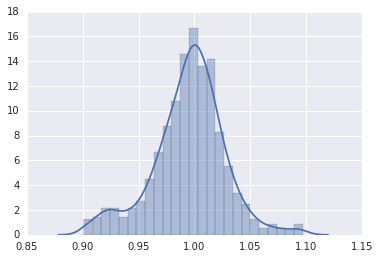

In [343]:
sns.distplot(bias)

In [40]:
%connect_info

{
  "stdin_port": 49627, 
  "ip": "127.0.0.1", 
  "control_port": 52852, 
  "hb_port": 55115, 
  "signature_scheme": "hmac-sha256", 
  "key": "2adb10bd-d4d4-4903-8998-4a1da37eeab3", 
  "kernel_name": "", 
  "shell_port": 40646, 
  "transport": "tcp", 
  "iopub_port": 33122
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /cluster/home/ifiddes/.local/share/jupyter/runtime/kernel-8c0b43c0-8559-419d-bfab-e74f021b83ed.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.
